In [29]:
import pandas as pd
import sklearn as sk
import nltk 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

### Importación de los datos y limpieza

In [30]:
import json
# Cargar la configuración desde un archivo JSON
with open("configura_local.json", encoding="utf-8") as f:
    config = json.load(f)

print("Ruta cargada:", config["data_path"])

Ruta cargada: C:/Users/jmuri/OneDrive/Escritorio/Stuff/Proyecto aprendizaje automático/archiverotten/rotten_tomatoes_critic_reviews.csv


In [31]:
file_path = json.load(open("configura_local.json", encoding="utf-8"))["data_path"]
df = pd.read_csv(file_path)

In [32]:
df.head(5)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [33]:
#Filtrado de columnas que se van a utilizar
columnas = ['review_score','review_content']
df = df[columnas]
df.head(5)

,review_score,review_content
0,NaN,A fantasy adventure that fuses Greek mythology...
1,NaN,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,NaN,With a top-notch cast and dazzling special eff...
3,3.5/5,Whether audiences will get behind The Lightnin...
4,NaN,What's really lacking in The Lightning Thief i...


In [34]:
# Eliminación de filas con valores nulos
df.dropna(inplace=True)

In [35]:
# Diccionario de conversión de letras a escala de 5 como fracción
letter_to_score = {
    'A': '5/5',
    'A-': '4.7/5',
    'B+': '4.3/5',
    'B': '4/5',
    'B-': '3.7/5',
    'C+': '3.3/5',
    'C': '3/5',
    'C-': '2.7/5',
    'D+': '2.3/5',
    'D': '2/5',
    'D-': '1.7/5',
    'F': '1/5',
}

# Función para reemplazar calificaciones de letra
def convert_score(score):
    score_str = str(score).strip()
    if score_str in letter_to_score:
        return letter_to_score[score_str]
    return score_str  # deja igual si ya es una fracción como "3.5/5"

# Aplica la función a la columna de calificaciones
df['review_score'] = df['review_score'].apply(convert_score)

In [36]:
df.head(5)

,review_score,review_content
3,3.5/5,Whether audiences will get behind The Lightnin...
6,1/4,Harry Potter knockoffs don't come more transpa...
7,3.5/5,"Percy Jackson isn't a great movie, but it's a ..."
8,4/5,"Fun, brisk and imaginative"
9,3/5,"Crammed with dragons, set-destroying fights an..."


In [37]:
# Convertir fracciones a número decimal
def fraction_to_float(score_str):
    try:
        num, den = score_str.split('/')
        return float(num) / float(den)
    except:
        return None  # para manejar errores o valores inesperados

df['review_score'] = df['review_score'].apply(fraction_to_float)


In [38]:
df.head(5)

,review_score,review_content
3,0.70,Whether audiences will get behind The Lightnin...
6,0.25,Harry Potter knockoffs don't come more transpa...
7,0.70,"Percy Jackson isn't a great movie, but it's a ..."
8,0.80,"Fun, brisk and imaginative"
9,0.60,"Crammed with dragons, set-destroying fights an..."


In [39]:
# Calcular la mediana
median_score = df['review_score'].median()
print("Mediana de review_score:", round(median_score, 3))

Mediana de review_score: 0.66


In [40]:
# Clasificar como 'positivo' si el score es mayor que la mediana, si no, 'negativo'
df['sentiment'] = df['review_score'].apply(
    lambda x: 'positivo' if x >= median_score else 'negativo'
)

In [41]:
df

,review_score,review_content,sentiment
3,0.70,Whether audiences will get behind The Lightnin...,positivo
6,0.25,Harry Potter knockoffs don't come more transpa...,negativo
7,0.70,"Percy Jackson isn't a great movie, but it's a ...",positivo
8,0.80,"Fun, brisk and imaginative",positivo
9,0.60,"Crammed with dragons, set-destroying fights an...",negativo
...,...,...,...
1130006,0.80,As a spectacular war film with a powerful mora...,positivo
1130013,0.70,"Seen today, it's not only a startling indictme...",positivo
1130014,0.86,A rousing visual spectacle that's a prequel of...,positivo
1130015,0.70,"A simple two-act story: Prelude to war, and th...",positivo


In [42]:
# Conteo de valores positivos y negativos de la columna 'sentiment'
print(df['sentiment'].value_counts())

sentiment
positivo    386805
negativo    371904
Name: count, dtype: int64


No queda balanceado exacto, pero resulta suficiente

In [43]:
# Filtrar las columnas que se van a utilizar
df = df[['review_content', 'sentiment']]

# Cambio de etiquetas de sentimiento a valores numéricos 
# 'positivo' a 1 y 'negativo' a 0
target_map = {'positivo': 1, 'negativo': 0}
df['sentiment'] = df['sentiment'].map(target_map)
df.head(5)

C:\Users\jmuri\AppData\Local\Temp\ipykernel_24680\683694738.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].map(target_map)


,review_content,sentiment
3,Whether audiences will get behind The Lightnin...,1
6,Harry Potter knockoffs don't come more transpa...,0
7,"Percy Jackson isn't a great movie, but it's a ...",1
8,"Fun, brisk and imaginative",1
9,"Crammed with dragons, set-destroying fights an...",0


Vamos entonces a crear nuestra división Train/Test

In [44]:
# Definir X e y
X = df['review_content']
y = df['sentiment']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80% entrenamiento, 20% testeo

# Verificación
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Testeo:", X_test.shape, y_test.shape)


Entrenamiento: (606967,) (606967,)
Testeo: (151742,) (151742,)


### Modelamiento

## Modelo Meme
Para empezar, vampos a  immplementar un modelo muy sencillo que tiene 50% de error. Nuestro trabajo será en las siguientes implementaciones mejorar los errores paulatinamente.

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Genera etiquetas aleatorias (0 o 1) para el conjunto de prueba
y_pred_random = np.random.choice([0, 1], size=len(y_test))

# Evalúa el desempeño del modelo aleatorio
print("Accuracy:", accuracy_score(y_test, y_pred_random))
print("F1 Score:", f1_score(y_test, y_pred_random))

Accuracy: 0.4997693453361627
F1 Score: 0.5052082654325012


Como era de esperarse el modelo solo calsifica bien el 50% de los datos

## Modelo de Vocabularios
Haremos un conteo de frecuencias, empíricamente y apoyándonos de la teoría encontraremos las expresiones que más se repiten en cada clase. Ejemplo: "awful" siendo muy presente en los textos negativos y "great" en textos positivos

Pero primero debemos hacer otra capa de preprocesamiento de los datos. Por el momoento, las observaciones en la base de datos df consisten solo de texto. Le haremos una tokenización, dividirlo en palabras, frases o caracteres, para hacer luego el conteo de frecuencias. Nos centraremos en eliminar puntuaciones indeseadas (mantenemos "!" y "?") y categorías gramaticales como artículos, preposiciones, conjunciones,..., también conectores que no alteren la polaridad a

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar recursos si no están
#nltk.download('punkt')
#nltk.download('stopwords')

In [ ]:
#import nltk
#nltk.download('punkt_tab')
def tokenizar_con_signos(texto):
    # Separar ? y ! con espacio si están pegados a una palabra
    texto = re.sub(r"([!?])", r" \1 ", texto)
    texto = re.sub(r"\s+", " ", texto)  # limpiar espacios duplicados
    return word_tokenize(texto.lower())
tokenizar_con_signos("That was great!")  # → ['that', 'was', 'great', '!']
tokenizar_con_signos("Not good?")        # → ['not', 'good', '?']


In [ ]:
# Función para limpiar texto y tokenizar
def limpiar_texto(texto):
    """
    Preprocesa un texto: lo pasa a minúsculas, elimina puntuación (excepto ? y !),
    tokeniza, y opcionalmente elimina stopwords.
    """
    # 1. Minúsculas
    texto = texto.lower()

    # 2. Eliminar puntuación excepto ? y !
    texto = re.sub(r"([!?])", r" \1 ", texto) #Separa ? y ! con espacio
    texto = re.sub(r"\s+", " ", texto)  # limpiar espacios duplicados
    texto = re.sub(r"[^a-zA-Z\s!?]", "", texto) # elimina todo excepto letras, espacios, ? y !

    # 3. Tokenizar
    tokens = word_tokenize(texto)

    # 4. Eliminar stopwords:
    sw = set(stopwords.words('english')) - {"not", "no", "nor", "don", "won",  "but"}  # conservamos palabras clave
    tokens = [word for word in tokens if word not in sw]

    return tokens

print(limpiar_texto("Wow! I did **not** expect that... 10/10 movie? Absolutely great! But my friend didn't like it."))

['wow', '!', 'not', 'expect', 'movie', '?', 'absolutely', 'great', '!', 'but', 'friend', 'didnt', 'like']


In [ ]:
from collections import Counter

# Tokenizar con la función que creamos personalizada limpiar_texto
X_train['tokens'] = X_train.apply(limpiar_texto)

In [41]:
# Aplanamos la lista de listas
todos_los_tokens_positivos = [
    token for tokens, label in zip(X_train["tokens"], y_train) if label == 1 for token in tokens
]

todos_los_tokens_negativos = [
    token for tokens, label in zip(X_train["tokens"], y_train) if label == 0 for token in tokens
]

# Contamos frecuencias
conteo_unigramas_pos = Counter(todos_los_tokens_positivos)
conteo_unigramas_neg = Counter(todos_los_tokens_negativos)

In [52]:
# Mostramos los 20 más comunes
print("Positivos:")
conteo_unigramas_pos.most_common(10)
#print("Negativos:")
#conteo_unigramas_neg.most_common(10)

Positivos:


[('but', 51786),
 ('film', 50362),
 ('movie', 32725),
 ('one', 28735),
 ('not', 25700),
 ('like', 18357),
 ('story', 18082),
 ('best', 14571),
 ('good', 12462),
 ('films', 12329)]

A continuación clasificamos cada unigrama en postitivo, neutro o negativo según está predominantemente en textos clasificados positivos o negativos.

In [99]:
def clasificar_unigramas(conteo_pos, conteo_neg, alpha=0.33):
    clasificacion = {}
    todos_los_tokens = set(conteo_pos) | set(conteo_neg)
    
    for token in todos_los_tokens:
        pos = conteo_pos.get(token, 0)
        neg = conteo_neg.get(token, 0)

        ratio = (pos + 1/alpha)/(pos + neg + 2/alpha) # para evitar división por cero y suavizar hacia 1/2 para evitar sobreajuste por bajas frecuencias
        if ratio > 1 - alpha:
            clasificacion[token] = "+"
        elif ratio < alpha:
            clasificacion[token] = "-"
        else:
            clasificacion[token] = "0"
    
    return clasificacion

clasificaciones = clasificar_unigramas(conteo_unigramas_pos, conteo_unigramas_neg, alpha=0.4)
# Imprime solo los primeros 50 tokens clasificados
print(list(clasificaciones.items())[:30])

[('shortlisted', '0'), ('cominatya', '0'), ('gothvampire', '0'), ('renversant', '0'), ('cantante', '-'), ('theatricality', '+'), ('kindafter', '-'), ('stinginess', '0'), ('presentdayonthesurfacemodern', '0'), ('specials', '0'), ('willwell', '0'), ('whoopee', '-'), ('styling', '0'), ('poorlyplotted', '0'), ('rompits', '0'), ('gladiatorially', '0'), ('nutsandbolts', '-'), ('heydrichrightfully', '0'), ('pseudomedieval', '0'), ('importara', '0'), ('allenstein', '0'), ('truthwhether', '0'), ('unhallowed', '0'), ('filippo', '0'), ('festor', '0'), ('deseja', '+'), ('confidante', '0'), ('terrariums', '0'), ('uncomfortable', '0'), ('nicolascage', '0')]


In [100]:
conteo_clasificaciones = Counter(clasificaciones.values())
print("Positivos:", conteo_clasificaciones["+"])
print("Negativos:", conteo_clasificaciones["-"])
print("Neutros:", conteo_clasificaciones["0"])

Positivos: 24272
Negativos: 25228
Neutros: 111409


In [144]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def clasificar_vocabulario(texto, clasificaciones, tokenizer):
    tokens = tokenizer(texto)
    votos = [clasificaciones.get(t, "0") for t in tokens]
    positivos = votos.count("+")
    negativos = votos.count("-")
    
    if positivos > negativos:
        return 1
    elif negativos > positivos:
        return 0
    else:
        return np.random.choice([0, 1])  # desempate aleatorio

In [102]:

# Aplica el clasificador a cada texto del conjunto de prueba
y_pred_voto = X_test.apply(lambda texto: clasificar_vocabulario(texto, clasificaciones, limpiar_texto))

# Evalúa el desempeño
print("Accuracy:", accuracy_score(y_test, y_pred_voto))
print("F1 Score:", f1_score(y_test, y_pred_voto))


Accuracy: 0.7228387657998445
F1 Score: 0.750319099042406


In [104]:
def puntaje_sentimiento(texto, clasificaciones):
    tokens = limpiar_texto(texto)  # usa tu tokenizer
    score = 0
    for token in tokens:
        if clasificaciones.get(token) == "+":
            score += 1
        elif clasificaciones.get(token) == "-":
            score -= 1
    return score

In [105]:
y_scores = [puntaje_sentimiento(texto, clasificaciones) for texto in X_test]

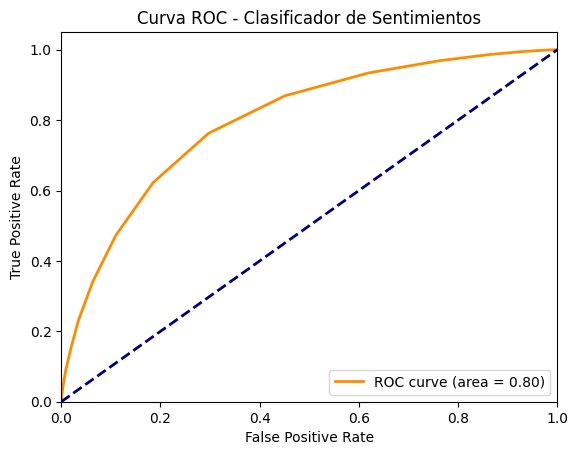

In [106]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificador de Sentimientos')
plt.legend(loc="lower right")
plt.show()


Nuestro modelo de Vocabularios arroja un buen resultado de predicción. Esto se debe a varios factores: los datos en la base de datos son suficientmente limpios, al tratarse de reseñas de películas la temática es clara y no se suelen encontrar datos basura como links; el modelo aunque simple funciona bien, el voto por mayoría permite garantiza que comentarios que utilizan más léxico de un sentimiento que el otro se clasifique por este (no siempre se cumple esto, pero es un comportamiento muy común), además, gracias a la frontera que define el hiperparámetro alpha se logra evadir sibreajustes de cuenta de frecuencias muy bajas.

Veamos qué valor es óptimo para el hiperparámetro alpha. Para esto, vamos a probar varios valores y ver cuál nos da mejor resultado en el conjunto de prueba. Haremos uso de Optuna

In [ ]:
%pip install --upgrade nbformat ipython plotly optuna

In [155]:
import optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.01, 0.49, log=True)  # Hiperparámetro alpha

    # Reentrenar el clasificador con nuevo alpha
    clasificaciones = clasificar_unigramas(conteo_unigramas_pos, conteo_unigramas_neg, alpha)
    y_pred = [clasificar_vocabulario(tokens, clasificaciones, limpiar_texto) for tokens in X_test[X_test['review_content'].apply(lambda x: isinstance(x, str))]]
    
    return f1_score(y_test, y_pred, pos_label='+')  # O ajusta según cómo manejes etiquetas

In [161]:
import optuna

def objective(trial):
    alpha = trial.suggest_float("alpha", 0.01, 0.49, log=True)  # Hiperparámetro alpha

    # Reentrenar el clasificador con nuevo alpha
    clasificaciones = clasificar_unigramas(conteo_unigramas_pos, conteo_unigramas_neg, alpha)

    # Filtrar entradas válidas y alinear y_test
    X_filtrado = X_test[X_test['review_content'].apply(lambda x: isinstance(x, str))]
    y_filtrado = y_test.loc[X_filtrado.index]

    y_pred = [clasificar_vocabulario(tokens, clasificaciones, limpiar_texto)
              for tokens in X_filtrado['review_content']]

    return f1_score(y_filtrado, y_pred, pos_label=1)  # Ajusta según etiquetas


In [162]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Mejor alpha:", study.best_params["alpha"])
print("Mejor F1 Score:", study.best_value)


[I 2025-07-19 21:55:31,659] A new study created in memory with name: no-name-efceaa1a-7285-4ca3-897b-20d86d21cc65
[I 2025-07-19 21:56:18,705] Trial 0 finished with value: 0.5340889087486967 and parameters: {'alpha': 0.15989346854283096}. Best is trial 0 with value: 0.5340889087486967.
[I 2025-07-19 21:57:00,875] Trial 1 finished with value: 0.5153453957182732 and parameters: {'alpha': 0.12133254266351437}. Best is trial 0 with value: 0.5340889087486967.
[I 2025-07-19 21:57:39,065] Trial 2 finished with value: 0.507801029696768 and parameters: {'alpha': 0.0488392689212695}. Best is trial 0 with value: 0.5340889087486967.
[I 2025-07-19 21:58:12,987] Trial 3 finished with value: 0.7514664182843938 and parameters: {'alpha': 0.4191219320011809}. Best is trial 3 with value: 0.7514664182843938.
[I 2025-07-19 21:58:51,429] Trial 4 finished with value: 0.5097492673396288 and parameters: {'alpha': 0.05430291655771415}. Best is trial 3 with value: 0.7514664182843938.
[I 2025-07-19 21:59:29,749] T

Mejor alpha: 0.4191219320011809
Mejor F1 Score: 0.7514664182843938


## Modelo Naive Bayes

In [ ]:
from nltk import NaiveBayesClassifier
def tokens_a_dict(tokens):
    return {token: True for token in tokens}

entrenamiento = [(tokens_a_dict(row), label) for row, label in zip(X_train['tokens'], y_train)]
modeloNB = NaiveBayesClassifier.train(entrenamiento)
modeloNB.classify(y_test)

In [139]:
#Evaluar la precisión del modelo Naive Bayes
# Paso 1: convertir los datos de prueba al formato adecuado
# Eliminar filas donde el contenido no sea tipo str
X_test = X_test[X_test['review_content'].apply(lambda x: isinstance(x, str))]
X_test['tokens'] = X_test['review_content'].apply(limpiar_texto)

In [140]:
# Paso 2: hacer predicciones
y_pred = [modeloNB.classify(features) for features in X_test_dicts]
# Paso 3: evaluar
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, pos_label=1))

Accuracy: 0.7520594166414045
F1 Score: 0.7629405130208498


Se puede observar que el clasificador de Naive Bayes de nltk tiene un desempeño muy similar al clasificador de Vocabulario que construimos, sospechamos que este estancamiento en los alrederdores del 70% se debe a la asumpción de independencia condicional entre las características (los tokens, es decir, las palabras). Nos despredemos de esa suposición y vamos a probar un modelo algo más complejo.

## Modelo de Bert-base-uncased

Exploraremos el modelo bert-base-uncased. Veremos que el desempeño del modelo será muy bajo ya que se tendrá que hacer una reducción de los conjuntos de entrenamiento en más de una milésima parte del set original. Esto por la cantidad de recursos que consume el modelo al momento de entrenarse, ya que en un primer intento de entrenamiento con el set de datos completo alcanzamos una hora y treinta minutos antes que el kernel de python se reiniciara por sobrecarga. 

In [17]:
# Realizaremos una reducción del tamaño del dataset para que sea más manejable

# Reducción del set de entrenamiento de 606,000 a 500 ejemplos balanceados
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train,
    train_size=500,
    stratify=y_train,
    random_state=42
)

# Reducción del set de test de 150,000 a 100 ejemplos balanceados
X_test_small, _, y_test_small, _ = train_test_split(
    X_test, y_test,
    train_size=100,
    stratify=y_test,
    random_state=42
)

In [ ]:
# Importar las librerías necesarias para el modelo BERT

from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.metrics import classification_report

# Creación del modelo BERT y el tokenizador

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenización de los textos

def tokenize_texts(texts):
    return tokenizer(texts, truncation=True, padding=True)

train_encodings = tokenize_texts(list(X_train_small))
val_encodings = tokenize_texts(list(X_test_small))

In [ ]:
# Creación de un Dataset personalizado para PyTorch

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.tolist())

    def __getitem__(self, idx):
        # Crea un diccionario con los tensores del encoding
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


# Creación de los datasets de entrenamiento y validación

train_dataset = SentimentDataset(train_encodings, y_train_small)
val_dataset = SentimentDataset(val_encodings, y_test_small)

In [ ]:
# Creación del modelo BERT para clasificación de secuencias

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
#Entreinamiento del modelo BERT

from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(2):  # Número de épocas
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1 - Loss: 0.7142
Epoch 2 - Loss: 0.7017


Hemos de notar que a pesar de la poca cantidad de datos, el tiempo de entrenamiento es significativamente alto, de aproximadamente 25 minutos. Y además obtuvimos un desempeño excesivamente bajo

In [50]:
#Evaluación del modelo BERT en el conjunto de test

import numpy as np
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
        true_labels.extend(batch["labels"].cpu().tolist())

# Calcular y mostrar el reporte de clasificación

print("\nClassification Report:")
print(classification_report(true_labels, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.51      1.00      0.68        51

    accuracy                           0.51       100
   macro avg       0.26      0.50      0.34       100
weighted avg       0.26      0.51      0.34       100



C:\Users\jmuri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jmuri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jmuri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_clas

Notemos que el modelo no pudo reconocer ningún texto negativo, es decir, calificó con 1 a todas las reseñas, y se podría pensar que el modelo no califica 0, pero se hizo una prueba posterior en un ejemplo especifico ("Awful") el cuál clasificó de manera correcta, con 0. Este ejemplo no se puede mostrar porque hubo un reinicio del kernel, por lo que se hubiera requerido nuevamente entrenar el modelo para hacer el ejemplo, lo cuál no nos pareció necesario.

Adicionalmente haciendo un recorrido de algunas de las reseñas en el conjunto de test pudimos evidenciar que tienen un lenguaje significantemente avanzado y "profesional" como para poder ser interpretable por el modelo poco entrenado. Haré una impresión del conjunto de test junto con sus clasificaciones reales para una buena visualización de lo mencionado.

In [28]:
for i in range(25):
    print(list(y_test_small)[i], list(X_test_small)[i])

1 Rent-A-Pal is an unexpected delight, the sort of movie that feels both like a throwback and very current, evoking feelings of isolation and loneliness that likely ring all too familiar to viewers at this moment in time.
1 Turns what could have been a sharply comic portrait of an inveterate buttinsky into a fatuously bland feature-length sitcom.
1 "A Star is Born" isn't perfect, but what Cooper and Gaga are able to do with the tale make it a delicate love story and triumphant tribute to the artistic spirit.
0 The Crazies falls into a run-hide-fight narrative loop that's not unlike a video game.
1 The acting is much above average for action films and takes advantage of the depth of an experienced actor like Bale.
0 Arbus (whose actual work is unseen, presumably because of rights issues) remains an enigma, and Kidman's wispy portrayal doesn't give the film the center it needs.
0 Watered-down beer.
1 Mileage will vary in the eyes of many viewers, and some might write it off as a curiosit

## Modelo de regresión logística

Ahora implemenatremos el modelo de regresión logística, un modelo clásico de clasificación. Utilizaremos un vectorizador de la librería sci-kit learn para transformar los valores en texto plano en vectores, posteriormente se hara entrenamiento y haremos un análisis de su rendimiento, el cuál es relativamente decente teniendo en cuenta la complejidad de los datos que tenemos, y que además es bastante cercano al del primer modelo implementado.

In [45]:
# Haremos una vectorización de los textos para un modelo de regresión logística

#Creación del vectorizador TF-IDF

vectorizer = TfidfVectorizer(max_features=2000)

# Vectorización de los conjuntos de entrenamiento y prueba

X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

In [ ]:
# Creación del modelo de regresión logística

model = LogisticRegression(max_iter=1000)

# Entrenamiento del modelo de regresión logística

model.fit(X_train_v, y_train)
print("Train accuracy:", model.score(X_train_v, y_train))
print("Test accuracy:", model.score(X_test_v, y_test))

Train acc: 0.7142447612473166
Test acc: 0.7131710403184353


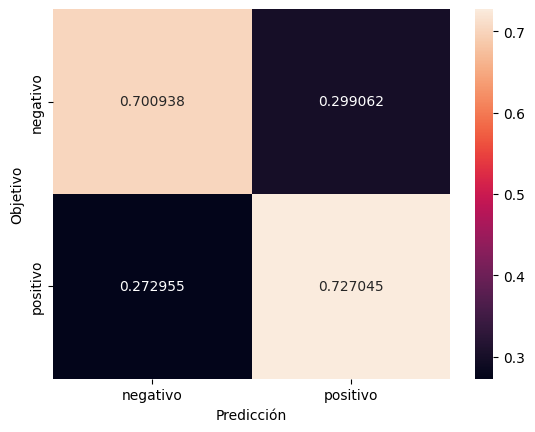

In [ ]:
#Graficación de la matriz de confusión

import seaborn as sn

P_train = model.predict(X_train_v)
P_test = model.predict(X_test_v)

cm = confusion_matrix(y_train, P_train, normalize='true')
cm

def plot_cm(cm):
    classes = ['negativo', 'positivo']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Objetivo")

plot_cm(cm)

Podemos observar que el modelo tuvo un accuracy de aproximadamente el 0.71, un valor muy similar al primer modelo y notablemente mejor que el modelo de bert, es un modelo más simple y rápido, que no requiere un poder computacional desbordante como el último y se asemeja en precisión al primer modelo, el cuál requirió más trabajo.

El modelo tuvo una tendencia a acertar en los valores positivos con respecto a los valores negativos pero no es una diferencia significativa. 

Veamos cuales son aquellas palabras con más peso positivo o negativo en el modelo y posteriormente expogamos algunos ejemplos en los cuales podría fallar el modelo para notar sus limitaciones.

In [ ]:
# Corte para visualizar las palabras más positivas y negativas

corte_pos = 3
corte_neg = -4
# Mapeo de indices
word_index_map = vectorizer.vocabulary_

#Visualización de las palabras más positivas y negativas

print("Palabras más negativas:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < corte_neg:
        print(word, weight)

print("\n")
print("Palabras más positivas:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > corte_pos:
        print(word, weight)

Palabras más negativas:
awful -4.123352651401961
fails -5.33296479029317
boring -4.2936461979221185
unfortunately -5.474197507327161
bland -4.5646569169551094
generic -4.1131258218205415
dull -4.79420001631984
waste -4.036258224466816
unfunny -5.442088028947151
disappointing -4.311650666695973
worst -5.18408370925312
sadly -4.228636713927542
mediocre -4.173555270616763
tedious -4.778200211541285
poorly -4.455643365891337


Palabras más positivas:
powerful 3.0770738022438624
brilliantly 3.823559112755812
finest 3.1867860429918795
masterpiece 4.026958551778975
devastating 3.168048997545658
rare 3.44921364514906
brilliant 3.515652150576581
wonderful 3.266394824992563
exhilarating 3.5268200926434963
masterful 3.3986293481093615
wonderfully 3.259129464830426
unforgettable 3.2034206200158737
gem 4.060593726107803
delightful 3.8240569722800855
mesmerizing 3.679063960418404
riveting 3.451755722501548
heartbreaking 3.035282473149093


In [78]:
# Ejemplos de reseñas y sus clasificaciones erroneas

prueba = ["Good movie if you want to lose your time", "Not good? I don't think so, it was really good",]

# Transformar la entrada con el vectorizador
x = vectorizer.transform(prueba)

# Predecir con el modelo
for i in range(len(prueba)):
    prediccion = model.predict(x[i])
    print(f"Reseña: {prueba[i]}")
    print(f"Clasificación predicha: {'positivo' if prediccion[0] == 1 else 'negativo'}")
    print("-" * 50)

Reseña: Good movie if you want to lose your time
Clasificación predicha: positivo
--------------------------------------------------
Reseña: Not good? I don't think so, it was really good
Clasificación predicha: negativo
--------------------------------------------------
